In [87]:
# MNIST KDE Training Notebook
# Ce notebook entraîne un modèle PCA + KDE sur MNIST

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from tensorflow import keras
import pickle
import os

In [88]:
# 1. Charger les données MNIST
print("Chargement des données MNIST...")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normaliser et aplatir les images
x_train_flat = x_train.reshape(-1, 784) / 255.0
x_test_flat = x_test.reshape(-1, 784) / 255.0

print(f"Shape des données d'entraînement: {x_train_flat.shape}")
print(f"Shape des données de test: {x_test_flat.shape}")

Chargement des données MNIST...
Shape des données d'entraînement: (60000, 784)
Shape des données de test: (10000, 784)



Entraînement du PCA...
Variance expliquée: 0.8246
Shape après PCA: (60000, 50)


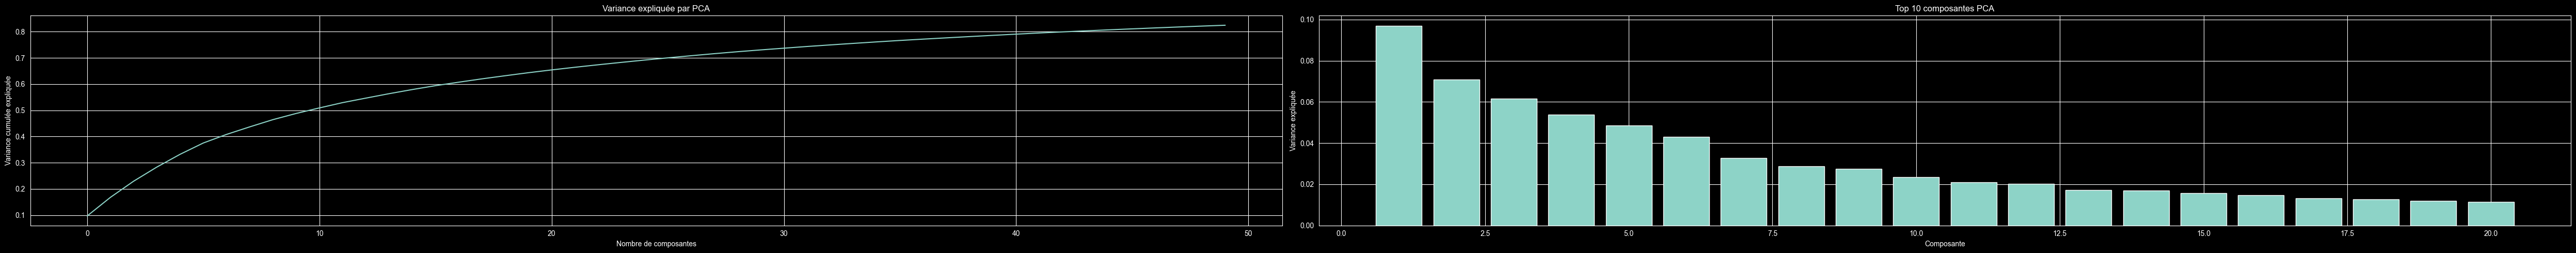

In [89]:
# 2. Réduction de dimensionnalité avec PCA
print("\nEntraînement du PCA...")
pca = PCA(n_components=50, random_state=42)
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

print(f"Variance expliquée: {pca.explained_variance_ratio_.sum():.4f}")
print(f"Shape après PCA: {x_train_pca.shape}")

# Visualiser la variance expliquée
plt.figure(figsize=(50, 5))
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulée expliquée')
plt.title('Variance expliquée par PCA')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(range(1, 21), pca.explained_variance_ratio_[:20])
plt.xlabel('Composante')
plt.ylabel('Variance expliquée')
plt.title('Top 10 composantes PCA')
plt.tight_layout()
plt.show()

In [90]:
# 3. Entraînement du KDE
print("\nEntraînement du KDE...")
n_samples_kde = 20000
indices = np.random.choice(len(x_train_pca), n_samples_kde, replace=False)
x_train_kde = x_train_pca[indices]

# Optimisation du bandwidth avec cross-validation
bandwidths = np.linspace(0.5, 2.0, 10)
best_bandwidth = None
best_score = -np.inf

print("Recherche du meilleur bandwidth...")
for bw in bandwidths:
    kde_temp = KernelDensity(bandwidth=bw, kernel='gaussian')
    kde_temp.fit(x_train_kde)
    score = kde_temp.score(x_test_pca[:1000])
    print(f"Bandwidth {bw:.2f}: score = {score:.4f}")
    if score > best_score:
        best_score = score
        best_bandwidth = bw

print(f"\nMeilleur bandwidth: {best_bandwidth:.2f}")

# Entraîner le modèle final
kde = KernelDensity(bandwidth=best_bandwidth, kernel='gaussian')
kde.fit(x_train_kde)

print(f"KDE entraîné sur {n_samples_kde} échantillons")


Entraînement du KDE...
Recherche du meilleur bandwidth...
Bandwidth 0.50: score = -41230.9396
Bandwidth 0.67: score = -47365.9475
Bandwidth 0.83: score = -53787.5049
Bandwidth 1.00: score = -60088.5280
Bandwidth 1.17: score = -65891.1285
Bandwidth 1.33: score = -71132.9856
Bandwidth 1.50: score = -75859.5027
Bandwidth 1.67: score = -80141.3546
Bandwidth 1.83: score = -84047.6072
Bandwidth 2.00: score = -87638.4103

Meilleur bandwidth: 0.50
KDE entraîné sur 20000 échantillons



Calcul des seuils pour rejection sampling...
Percentile 10%: -48.8307
Percentile 25%: -44.3576
Percentile 50%: -33.2460


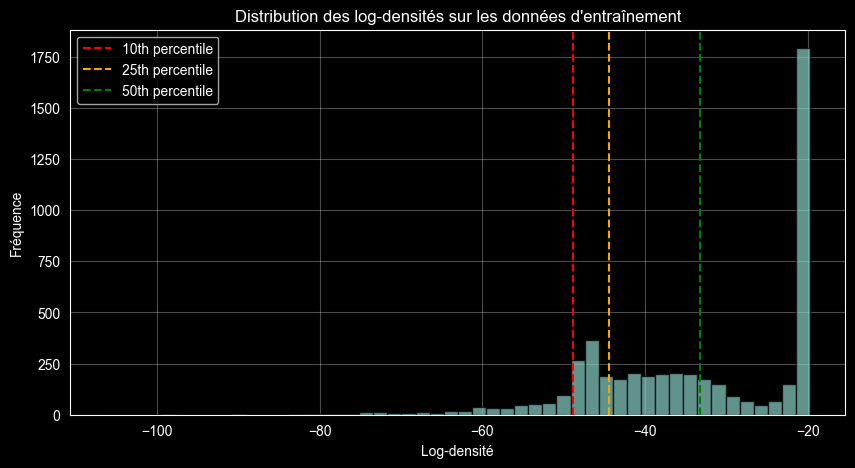

In [91]:
# 4. Calculer les statistiques pour le rejection sampling
print("\nCalcul des seuils pour rejection sampling...")

# Calculer les log-densités des données d'entraînement
train_log_densities = kde.score_samples(x_train_pca[:5000])

# Définir les percentiles pour le rejection sampling
percentile_10 = np.percentile(train_log_densities, 10)
percentile_25 = np.percentile(train_log_densities, 25)
percentile_50 = np.percentile(train_log_densities, 50)

print(f"Percentile 10%: {percentile_10:.4f}")
print(f"Percentile 25%: {percentile_25:.4f}")
print(f"Percentile 50%: {percentile_50:.4f}")

# Visualiser la distribution des densités
plt.figure(figsize=(10, 5))
plt.hist(train_log_densities, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(percentile_10, color='red', linestyle='--', label='10th percentile')
plt.axvline(percentile_25, color='orange', linestyle='--', label='25th percentile')
plt.axvline(percentile_50, color='green', linestyle='--', label='50th percentile')
plt.xlabel('Log-densité')
plt.ylabel('Fréquence')
plt.title('Distribution des log-densités sur les données d\'entraînement')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Test de génération d'échantillons...


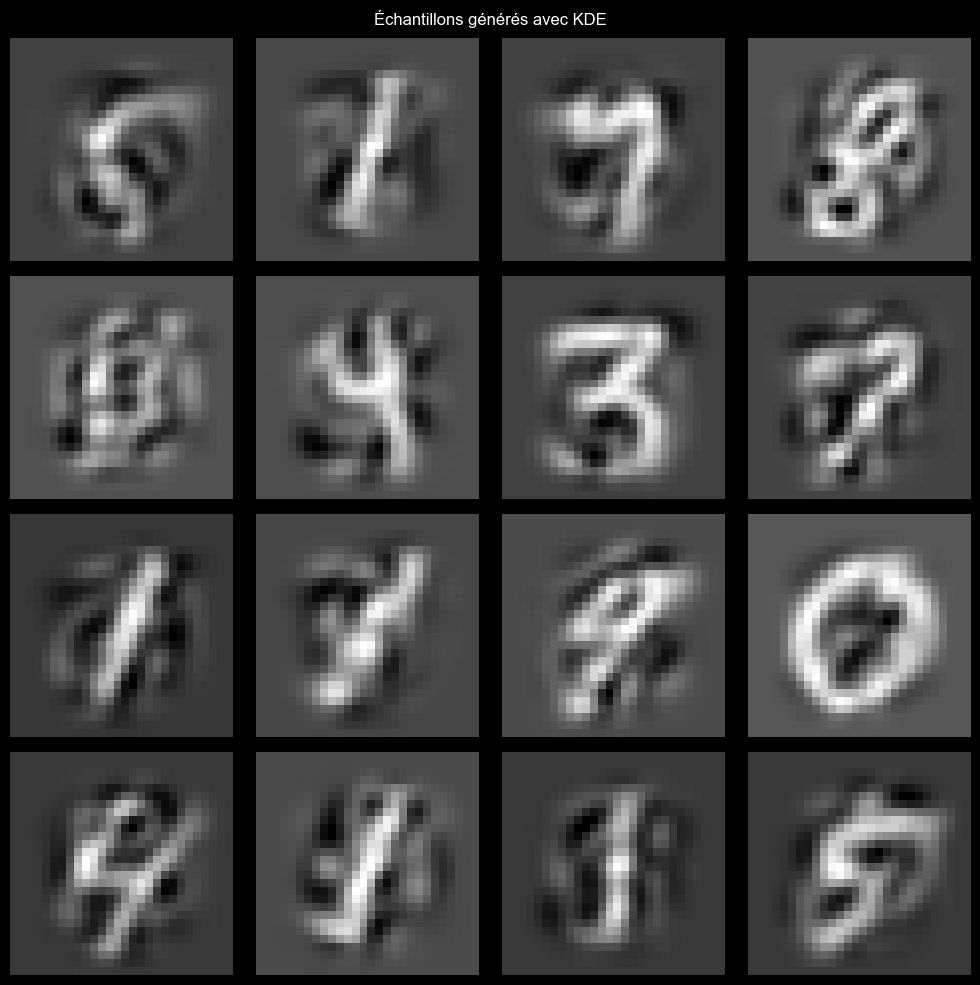

In [92]:
# 5. Test de génération
print("\nTest de génération d'échantillons...")
n_samples = 16
samples_pca = kde.sample(n_samples, random_state=42)
samples_reconstructed = pca.inverse_transform(samples_pca)
samples_images = samples_reconstructed.reshape(-1, 28, 28)

# Visualiser les échantillons générés
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples_images[i], cmap='gray')
    ax.axis('off')
plt.suptitle('Échantillons générés avec KDE')
plt.tight_layout()
plt.show()

In [93]:
# 5. Fonction de génération avec rejection sampling
def generate_samples_with_rejection(kde, pca, n_samples, threshold_percentile=25,
                                   max_attempts=10000, random_state=None):
    """
    Génère des échantillons avec rejection sampling

    Args:
        kde: Modèle KDE entraîné
        pca: Modèle PCA entraîné
        n_samples: Nombre d'échantillons à générer
        threshold_percentile: Percentile de log-densité minimum (10, 25, ou 50)
        max_attempts: Nombre maximum de tentatives
        random_state: Seed pour reproductibilité

    Returns:
        accepted_images: Images acceptées (n_samples, 28, 28)
        acceptance_rate: Taux d'acceptation
    """
    if random_state is not None:
        np.random.seed(random_state)

    # Déterminer le seuil basé sur le percentile
    thresholds = {10: percentile_10, 25: percentile_25, 50: percentile_50}
    threshold = thresholds.get(threshold_percentile, percentile_25)

    accepted_samples = []
    attempts = 0

    while len(accepted_samples) < n_samples and attempts < max_attempts:
        # Générer un batch de candidats
        batch_size = min(n_samples * 5, 1000)
        candidates_pca = kde.sample(batch_size)

        # Calculer les log-densités
        log_densities = kde.score_samples(candidates_pca)

        # Accepter les échantillons au-dessus du seuil
        accepted_mask = log_densities >= threshold
        accepted_batch = candidates_pca[accepted_mask]

        accepted_samples.extend(accepted_batch[:n_samples - len(accepted_samples)])
        attempts += batch_size

    accepted_samples = np.array(accepted_samples[:n_samples])

    # Reconstruire les images
    samples_flat = pca.inverse_transform(accepted_samples)
    samples_flat = np.clip(samples_flat, 0, 1)
    samples_images = samples_flat.reshape(-1, 28, 28)

    acceptance_rate = len(accepted_samples) / attempts if attempts > 0 else 0

    return samples_images, acceptance_rate


=== Comparaison des méthodes de génération ===

1. Sans rejection sampling:
2. Avec rejection sampling (percentile 10%):
   Taux d'acceptation: 20.00%
3. Avec rejection sampling (percentile 25%):
   Taux d'acceptation: 20.00%
4. Avec rejection sampling (percentile 50%):
   Taux d'acceptation: 0.16%


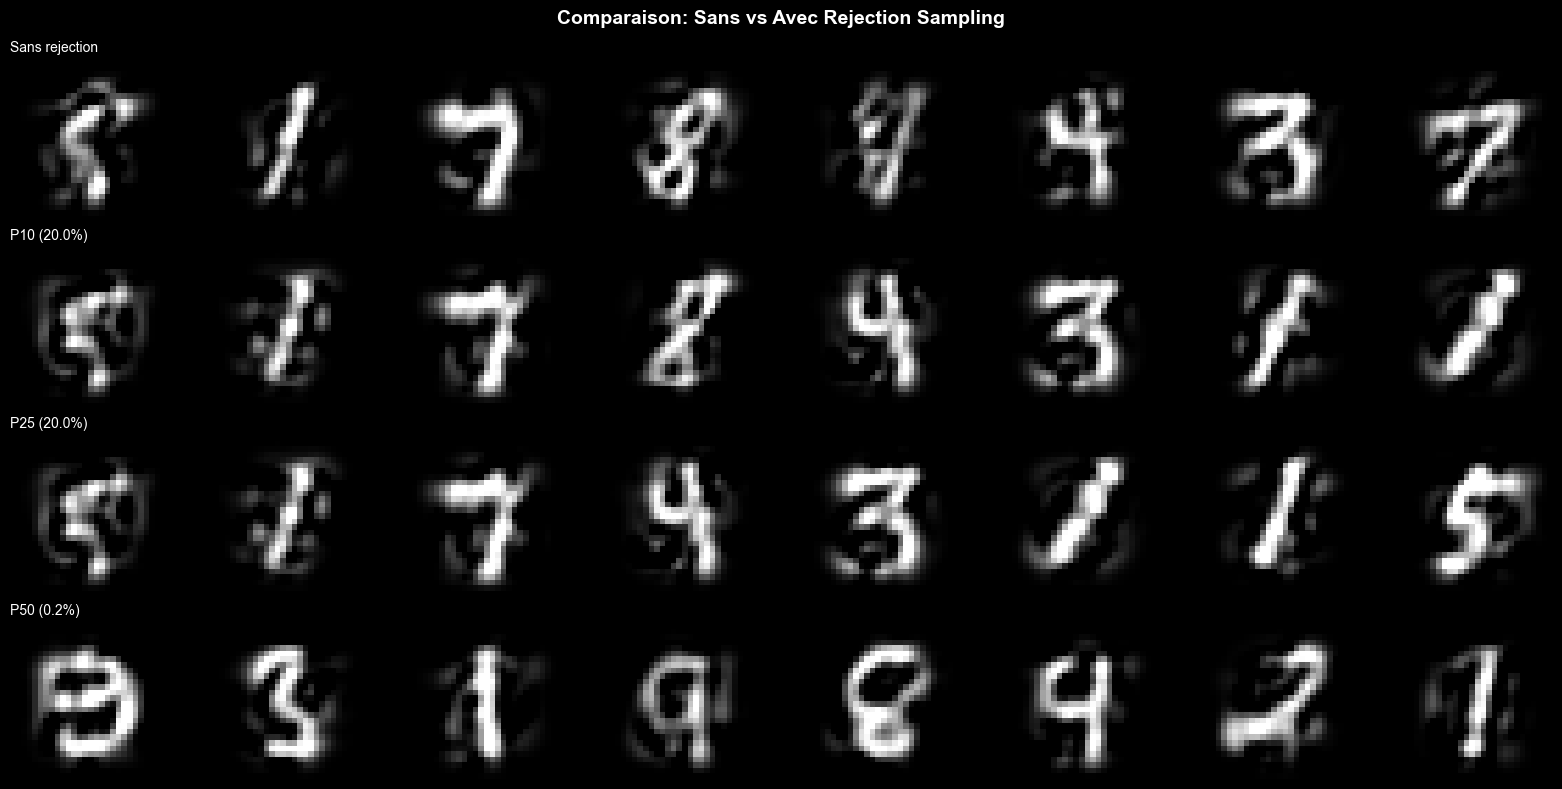

In [94]:
# 6. Test avec différents seuils
print("\n=== Comparaison des méthodes de génération ===\n")

fig, axes = plt.subplots(4, 8, figsize=(16, 8))

# Sans rejection sampling
print("1. Sans rejection sampling:")
samples_no_rejection = kde.sample(8, random_state=42)
samples_no_rejection = pca.inverse_transform(samples_no_rejection)
samples_no_rejection = np.clip(samples_no_rejection, 0, 1).reshape(-1, 28, 28)

for i in range(8):
    axes[0, i].imshow(samples_no_rejection[i], cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Sans rejection', fontsize=10, loc='left')

# Avec rejection sampling - percentile 10
print("2. Avec rejection sampling (percentile 10%):")
samples_p10, rate_p10 = generate_samples_with_rejection(
    kde, pca, 8, threshold_percentile=10, random_state=42)
print(f"   Taux d'acceptation: {rate_p10:.2%}")

for i in range(8):
    axes[1, i].imshow(samples_p10[i], cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title(f'P10 ({rate_p10:.1%})', fontsize=10, loc='left')

# Avec rejection sampling - percentile 25
print("3. Avec rejection sampling (percentile 25%):")
samples_p25, rate_p25 = generate_samples_with_rejection(
    kde, pca, 8, threshold_percentile=25, random_state=42)
print(f"   Taux d'acceptation: {rate_p25:.2%}")

for i in range(8):
    axes[2, i].imshow(samples_p25[i], cmap='gray')
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_title(f'P25 ({rate_p25:.1%})', fontsize=10, loc='left')

# Avec rejection sampling - percentile 50
print("4. Avec rejection sampling (percentile 50%):")
samples_p50, rate_p50 = generate_samples_with_rejection(
    kde, pca, 8, threshold_percentile=50, random_state=42)
print(f"   Taux d'acceptation: {rate_p50:.2%}")

for i in range(8):
    axes[3, i].imshow(samples_p50[i], cmap='gray')
    axes[3, i].axis('off')
    if i == 0:
        axes[3, i].set_title(f'P50 ({rate_p50:.1%})', fontsize=10, loc='left')

plt.suptitle('Comparaison: Sans vs Avec Rejection Sampling', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [95]:
# 7. Comparaison quantitative
print("\n=== Analyse quantitative ===")

def compute_quality_metrics(samples):
    """Calcule des métriques de qualité pour les échantillons"""
    # Entropie moyenne (mesure de la structure)
    entropy = -np.sum(samples * np.log(samples + 1e-10), axis=(1, 2)).mean()

    # Variance moyenne (mesure du contraste)
    variance = samples.var(axis=(1, 2)).mean()

    # Proportion de pixels "actifs" (> 0.1)
    active_pixels = (samples > 0.1).mean()

    return {
        'entropy': entropy,
        'variance': variance,
        'active_pixels': active_pixels
    }

methods = [
    ('Sans rejection', samples_no_rejection),
    ('Percentile 10%', samples_p10),
    ('Percentile 25%', samples_p25),
    ('Percentile 50%', samples_p50)
]

print("\nMétriques de qualité:")
print("-" * 60)
for name, samples in methods:
    metrics = compute_quality_metrics(samples)
    print(f"{name:20} | Entropie: {metrics['entropy']:.4f} | "
          f"Variance: {metrics['variance']:.4f} | "
          f"Pixels actifs: {metrics['active_pixels']:.2%}")


=== Analyse quantitative ===

Métriques de qualité:
------------------------------------------------------------
Sans rejection       | Entropie: 69.7865 | Variance: 0.0642 | Pixels actifs: 25.92%
Percentile 10%       | Entropie: 68.5380 | Variance: 0.0656 | Pixels actifs: 25.77%
Percentile 25%       | Entropie: 68.6696 | Variance: 0.0680 | Pixels actifs: 26.12%
Percentile 50%       | Entropie: 66.6930 | Variance: 0.0705 | Pixels actifs: 26.13%


In [96]:
# 8. Sauvegarder les modèles et seuils
print("\n=== Sauvegarde des modèles ===")
os.makedirs('../models', exist_ok=True)

with open('../models/pca_model.pkl', 'wb') as f:
    pickle.dump(pca, f)

with open('../models/kde_model.pkl', 'wb') as f:
    pickle.dump(kde, f)

# Sauvegarder aussi les seuils de rejection sampling
rejection_params = {
    'percentile_10': percentile_10,
    'percentile_25': percentile_25,
    'percentile_50': percentile_50,
    'default_percentile': 25  # Valeur par défaut recommandée
}

with open('../models/rejection_params.pkl', 'wb') as f:
    pickle.dump(rejection_params, f)

print("✓ Modèles sauvegardés dans le dossier 'models/'")
print("  - pca_model.pkl")
print("  - kde_model.pkl")
print("  - rejection_params.pkl (nouveau!)")

print("\n" + "="*60)
print("ENTRAÎNEMENT TERMINÉ!")
print("="*60)
print(f"PCA: 784 → 50 dimensions ({pca.explained_variance_ratio_.sum():.1%} variance)")
print(f"KDE: bandwidth = {best_bandwidth:.2f}")
print(f"\nRejection Sampling:")
print(f"  - Percentile 10%: taux d'acceptation ~{rate_p10:.1%}")
print(f"  - Percentile 25%: taux d'acceptation ~{rate_p25:.1%} (recommandé)")
print(f"  - Percentile 50%: taux d'acceptation ~{rate_p50:.1%}")
print("\n💡 Conseil: Utilisez percentile 25% pour un bon équilibre qualité/vitesse")


=== Sauvegarde des modèles ===
✓ Modèles sauvegardés dans le dossier 'models/'
  - pca_model.pkl
  - kde_model.pkl
  - rejection_params.pkl (nouveau!)

ENTRAÎNEMENT TERMINÉ!
PCA: 784 → 50 dimensions (82.5% variance)
KDE: bandwidth = 0.50

Rejection Sampling:
  - Percentile 10%: taux d'acceptation ~20.0%
  - Percentile 25%: taux d'acceptation ~20.0% (recommandé)
  - Percentile 50%: taux d'acceptation ~0.2%

💡 Conseil: Utilisez percentile 25% pour un bon équilibre qualité/vitesse
